In [1]:
# Imports:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.metrics import mean_squared_error
import plotly.express as px
from scipy import stats
import random as random

In [2]:
#set seed for reproducibility
random_state = 42
np.random.seed(random_state)

In [3]:
with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/pickle files/bi_directional_norway_dataset_dict.pickle', 'rb') as f:
    norway_data_dict = pickle.load(f)

In [4]:
norway_data = pd.read_csv(r'/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/resources/norway_cpi_dataset.csv')

In [5]:
norway_data.head()

,Unnamed: 0,Date,Category,Category_id,Price,Weight,Indent,Parent,Parent_ID
0,0,2009-01-15,All-items,0,88.7,1000.0,0,NaN,NaN
1,1,2009-02-15,All-items,0,89.4,1000.0,0,NaN,NaN
2,2,2009-03-15,All-items,0,89.4,1000.0,0,NaN,NaN
3,3,2009-04-15,All-items,0,89.7,1000.0,0,NaN,NaN
4,4,2009-05-15,All-items,0,89.9,1000.0,0,NaN,NaN


In [6]:
norway_data.groupby('Indent').Price.describe(percentiles = [0.05,0.1,0.25,0.5,0.75,0.9,0.95]).round(2)

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
Indent,,,,,,,,,,,,
0,173.0,103.73,10.43,88.7,90.4,92.1,94.2,102.5,111.2,118.04,124.76,129.6
1,2076.0,103.57,11.43,78.2,86.7,90.3,94.8,102.7,111.2,118.70,125.50,138.8
2,6747.0,104.29,14.87,71.5,85.8,89.2,95.8,102.5,110.0,120.40,127.97,270.5


In [7]:
norway_data.groupby('Indent').Category_id.nunique().reset_index()

,Indent,Category_id
0,0,1
1,1,12
2,2,39


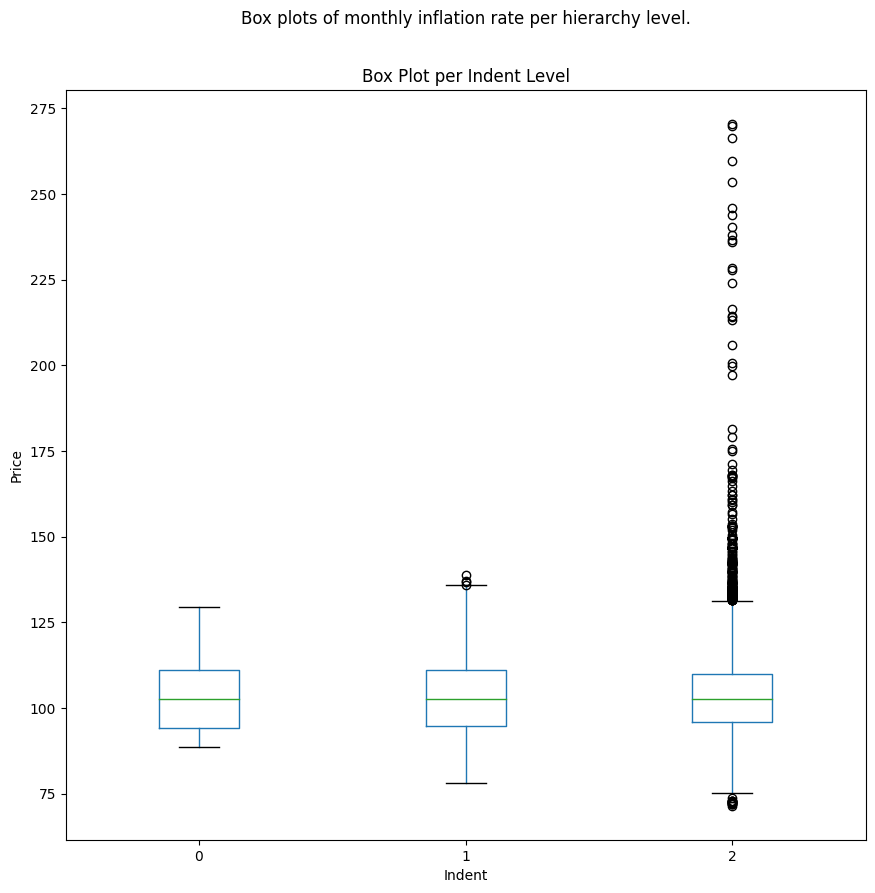

In [8]:
# Create box plots for each indent level
norway_data.boxplot(column='Price', by='Indent', grid=False, figsize=(10,10))
plt.title('Box Plot per Indent Level')
plt.xlabel('Indent')
plt.ylabel('Price')
plt.suptitle('Box plots of monthly inflation rate per hierarchy level.') 
plt.show()

--------

### Horizon Analyses:

In [9]:
# import horizon files 
with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1 - norway/data/hor1_test_dataset.pickle', 'rb') as f:
    norway_hor_1_test_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1 - norway/data/hor2_test_dataset.pickle', 'rb') as f:
    norway_hor_2_test_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1 - norway/data/hor3_test_dataset.pickle', 'rb') as f:
    norway_hor_3_test_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1 - norway/data/hor4_test_dataset.pickle', 'rb') as f:
    norway_hor_4_test_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1 - norway/data/hor8_test_dataset.pickle', 'rb') as f:
    norway_hor_8_test_dict = pickle.load(f)

In [10]:
import sys        
sys.path.append('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1 - norway')       
import model
from model.GRU_model import *
from pipeline_config import *
from model.config import * 
from model.utils import *
Lr = 0.09368413467461317

2023-09-30 23:23:22.300296: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
num_forecast_steps = 8

category_horizon_dict = {}

for category_name in list(norway_hor_1_test_dict.keys()):
    # load model
    cat_model = GRUModel(input_dim=Features, hidden_dim=HiddenSize, layer_dim=LayersDim, output_dim=OutputDim, dropout_prob=DropoutProb)
    cat_optimizer = torch.optim.AdamW(cat_model.parameters(), lr=Lr)
    cat_model.to(Device)

    category_model, optimizer, checkpoint, valid_loss_min = load_checkpoint('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1 - norway/models_weights/'+category_name+'.pt', cat_model, cat_optimizer)

    horizon_dict = {}

    # Generate forecasts step by step
    for step in range(num_forecast_steps):
        with torch.no_grad():
            # create dataloader
            x_test = norway_hor_1_test_dict[category_name].iloc[:,:-1].to_numpy()
            y_test= norway_hor_1_test_dict[category_name].iloc[:,-1:].to_numpy()

            x_test = torch.from_numpy(x_test).to(torch.float32)
            y_test = torch.from_numpy(y_test).to(torch.float32)

            test_dataset = TensorDataset(x_test, y_test)

            test_dataloader =  DataLoader(test_dataset, batch_size=BatchSize, shuffle=False)

            for inputs, labels in test_dataloader:
                # since each batch contains 32 samples, and the largest df is of size 32, then we dont need to concat the outputs per batch per category.
                inputs = inputs.view(inputs.shape[0], SequenceLength, Features)
                #print(f'inputs shape: {inputs.shape}')
                #print(f'labels shape: {labels.shape}')
                inputs, labels = inputs.to(Device), labels.to(Device)
                out = category_model(inputs)
                out_df = pd.DataFrame(out)
                
                first = norway_hor_1_test_dict[category_name].iloc[:,1:].reset_index(drop = True).copy()
                print(f'first shape: {first.shape}')
                second = out_df.reset_index(drop = True).rename(columns = {0: 'Inflation t+'+str(2+step)})
                print(f'second shape: {second.shape}')

                norway_hor_1_test_dict[category_name] = pd.concat([first, second],axis=1) #prediction

                horizon_dict[step+2] = norway_hor_1_test_dict[category_name]

    category_horizon_dict[category_name] = horizon_dict
    


first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second shape: (29, 1)
first shape: (29, 13)
second sha

In [12]:
def avg_rmse_hor(prediction_dict, actual_dict, horizon):
    mse_lst = []
    for key in list(actual_dict.keys()):
        predictions = prediction_dict[key][horizon].iloc[:,-1:].reset_index(drop = True)
        actuals = actual_dict[key].iloc[:,-1:].reset_index(drop = True)

        y_pred = predictions.values
        y_actual = actuals.values

        non_null_indices = ~np.isnan(y_pred) & ~np.isnan(y_actual)

        predicted_values_non_null = y_pred[non_null_indices]
        observed_values_non_null = y_actual[non_null_indices]

        #print(f'y pred: {predicted_values_non_null}')
        #print(f'y actual: {observed_values_non_null}')
        mse = mean_squared_error(predicted_values_non_null, observed_values_non_null)
        mse_lst.append(mse)
    
    rmse_list = list(map(np.sqrt,mse_lst))
    avg_rmse = np.mean(rmse_list)
    rmse_std = np.std(rmse_list)
    
    print(f'RMSE:  {avg_rmse}')
    print(f'MSE std:  {rmse_std}')
    print(f'interval: {[avg_rmse-rmse_std, avg_rmse+rmse_std]}')

    return avg_rmse,rmse_std

In [13]:
avg_rmse_hor(category_horizon_dict, norway_hor_2_test_dict, 2)

RMSE:  2.1308882553995945
MSE std:  2.0475021022444144
interval: [0.08338615315518005, 4.178390357644009]


(2.1308882553995945, 2.0475021022444144)

In [14]:
avg_rmse_hor(category_horizon_dict, norway_hor_3_test_dict, 3)

RMSE:  2.1130372022487336
MSE std:  2.026649257992312
interval: [0.08638794425642171, 4.1396864602410455]


(2.1130372022487336, 2.026649257992312)

In [15]:
avg_rmse_hor(category_horizon_dict, norway_hor_4_test_dict, 4)

RMSE:  2.0380305380927473
MSE std:  1.895715940255878
interval: [0.14231459783686917, 3.9337464783486253]


(2.0380305380927473, 1.895715940255878)

In [16]:
avg_rmse_hor(category_horizon_dict, norway_hor_8_test_dict, 8)

RMSE:  2.193577287632233
MSE std:  2.2984570096373487
interval: [-0.10487972200511564, 4.492034297269582]


(2.193577287632233, 2.2984570096373487)

In [17]:
#category_horizon_dict - prediction dict per category per horizon
# us_hor_x_test_dict - actual dict per category for horizon x

In [18]:
with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/pickle files/bi_directional_norway_2_period_dataset_dict.pickle', 'rb') as f:
    hor_2_raw_dataset_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/pickle files/bi_directional_norway_3_period_dataset_dict.pickle', 'rb') as f:
    hor_3_raw_dataset_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/pickle files/bi_directional_norway_4_period_dataset_dict.pickle', 'rb') as f:
    hor_4_raw_dataset_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/pickle files/bi_directional_norway_8_period_dataset_dict.pickle', 'rb') as f:
    hor_8_raw_dataset_dict = pickle.load(f)

In [19]:
def create_test_dataframe(raw_dataset_dict: dict, horizon:int):
    test_dict = {}
    for key in raw_dataset_dict.keys():
        df = raw_dataset_dict[key][['Category', 'Date', 'Year', 'Inflation t+'+str(horizon)]]
        df.dropna(inplace=True)
        df.rename(columns={'Inflation t+'+str(horizon): 'Actual Horizon '+str(horizon)}, inplace=True)
        target_df = df[df['Year'] > 2020]
        target_df = target_df.reset_index(drop = True)
        test_dict[key] = target_df
    return test_dict

In [20]:
test_dict_hor_2 = create_test_dataframe(hor_2_raw_dataset_dict, 2)
test_dict_hor_3 = create_test_dataframe(hor_3_raw_dataset_dict, 3)
test_dict_hor_4 = create_test_dataframe(hor_4_raw_dataset_dict, 4)
test_dict_hor_8 = create_test_dataframe(hor_8_raw_dataset_dict, 8)


/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_9865/3431962343.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_9865/3431962343.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Inflation t+'+str(horizon): 'Actual Horizon '+str(horizon)}, inplace=True)
/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_9865/3431962343.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [21]:
def get_df_with_predictions_horizon(prediction_dic: dict, actual_dic:dict, horizon: int) -> dict:
    all_data_dict = {}
    for key in list(prediction_dic.keys()):
        predictions = prediction_dic[key][horizon].iloc[:,-1:].reset_index(drop = True)
        predictions = predictions.rename(columns = {f'Inflation t+{horizon}': f'Prediction Horizon {horizon}'})
        actuals = actual_dic[key]

        data = pd.concat([predictions, actuals], axis=1).loc[:,['Category','Date','Year',f'Prediction Horizon {horizon}', f'Actual Horizon {horizon}']]
        all_data_dict[key] = data
        
    return all_data_dict

In [22]:
all_data_test_dict_hor_2 = get_df_with_predictions_horizon(category_horizon_dict, test_dict_hor_2,2)
all_data_test_dict_hor_3 = get_df_with_predictions_horizon(category_horizon_dict, test_dict_hor_3,3)
all_data_test_dict_hor_4 = get_df_with_predictions_horizon(category_horizon_dict, test_dict_hor_4,4)
all_data_test_dict_hor_8 = get_df_with_predictions_horizon(category_horizon_dict, test_dict_hor_8,8)

In [23]:
all_data_test_dict_hor_2['All-items']

,Category,Date,Year,Prediction Horizon 2,Actual Horizon 2
0,All-items,2021-01-15,2021.0,0.281504,-0.261438
1,All-items,2021-02-15,2021.0,0.022111,0.348432
2,All-items,2021-03-15,2021.0,0.303705,-0.086994
3,All-items,2021-04-15,2021.0,0.320605,0.347524
4,All-items,2021-05-15,2021.0,0.315616,0.863563
5,All-items,2021-06-15,2021.0,0.352445,0.000000
6,All-items,2021-07-15,2021.0,-0.132283,1.026527
7,All-items,2021-08-15,2021.0,0.387970,-0.255646
8,All-items,2021-09-15,2021.0,-0.284256,0.764985
9,All-items,2021-10-15,2021.0,0.117675,0.675108


In [24]:
def plot_results_horizon(all_data_dict, categories, horizon):
    #category_samples = random.sample(categories, 5)+['All items']
    category_samples = categories
    for category in category_samples:
        category_df = all_data_dict[category]
        y_pred = category_df[f'Prediction Horizon {horizon}'].values
        y_actual = category_df[f'Actual Horizon {horizon}'].values

        non_null_indices = ~np.isnan(y_pred) & ~np.isnan(y_actual)

        predicted_values_non_null = y_pred[non_null_indices]
        observed_values_non_null = y_actual[non_null_indices]

        mse = mean_squared_error(predicted_values_non_null, observed_values_non_null)
        print(f'Category is: {category}')
        print(f'RMSE is: {np.sqrt(mse)}')

        fig = px.line(category_df, x="Date", y=[f'Actual Horizon {horizon}', f'Prediction Horizon {horizon}'], title=f'{category} - Actual VS Prediction: horizon {horizon}')
        fig.show()



In [25]:
def total_corr_horizon(all_data_test_dict, horizon):
    corr_dict = {}
    for key in list(all_data_test_dict.keys()):
        df = all_data_test_dict[key]
        y_pred = df[f'Prediction Horizon {horizon}'].values
        y_actual = df[f'Actual Horizon {horizon}'].values

        non_null_indices = ~np.isnan(y_pred) & ~np.isnan(y_actual)

        predicted_values_non_null = y_pred[non_null_indices]
        observed_values_non_null = y_actual[non_null_indices]

        corr = stats.pearsonr(predicted_values_non_null,observed_values_non_null)[0]
        corr_dict[key] =  corr
    
    total_corr = sum(corr_dict.values())
    
    num_high_corr = 0
    for category in corr_dict:
        if corr_dict[category] >= 0.5:
            num_high_corr +=1
    
    print(f'Number of categories with High Correlation: {num_high_corr}')
    print(f'Total Corr Horizon {horizon}, {total_corr}')
    return total_corr

In [26]:
total_corr_horizon(all_data_test_dict_hor_2, 2)
total_corr_horizon(all_data_test_dict_hor_3, 3)
total_corr_horizon(all_data_test_dict_hor_4, 4)
total_corr_horizon(all_data_test_dict_hor_8, 8)

Number of categories with High Correlation: 0
Total Corr Horizon 2, -3.63244395513706
Number of categories with High Correlation: 2
Total Corr Horizon 3, 2.4889757787849143
Number of categories with High Correlation: 0
Total Corr Horizon 4, 1.0837771037922883
Number of categories with High Correlation: 0
Total Corr Horizon 8, -3.5061396401210536


-3.5061396401210536

In [27]:
cats = list(all_data_test_dict_hor_2.keys())
categories = random.sample(cats, 5)+['All-items']

In [28]:
#categories = list(all_data_test_dict_hor_2.keys())
plot_results_horizon(all_data_test_dict_hor_2, categories, 2)

Category is: Furnishings, household equipment and routine maintenance
RMSE is: 3.4569154539154066


Category is: Personal effects n.e.c.
RMSE is: 1.0040360434992106


Category is: Out-patient services
RMSE is: 0.5582163761551835


Category is: Communications
RMSE is: 0.8685638314345435


Category is: Imputed rentals for housing
RMSE is: 0.2009503675887256


Category is: All-items
RMSE is: 0.6990453295052005


In [29]:
#categories = list(all_data_test_dict_hor_3.keys())
plot_results_horizon(all_data_test_dict_hor_3, categories, 3)

Category is: Furnishings, household equipment and routine maintenance
RMSE is: 2.0678057412240536


Category is: Personal effects n.e.c.
RMSE is: 1.1039261313956716


Category is: Out-patient services
RMSE is: 0.5460955672011354


Category is: Communications
RMSE is: 0.8352334691247794


Category is: Imputed rentals for housing
RMSE is: 0.212406905000793


Category is: All-items
RMSE is: 0.6685876465475405


In [30]:
#categories = list(all_data_test_dict_hor_4.keys())
plot_results_horizon(all_data_test_dict_hor_4, categories, 4)

Category is: Furnishings, household equipment and routine maintenance
RMSE is: 2.518374020618426


Category is: Personal effects n.e.c.
RMSE is: 1.1034657941004338


Category is: Out-patient services
RMSE is: 0.4855532431838782


Category is: Communications
RMSE is: 0.8598594584129353


Category is: Imputed rentals for housing
RMSE is: 0.23450111057050504


Category is: All-items
RMSE is: 0.614516705800408


In [31]:
#categories = list(all_data_test_dict_hor_8.keys())
plot_results_horizon(all_data_test_dict_hor_8, categories, 8)

Category is: Furnishings, household equipment and routine maintenance
RMSE is: 2.904600765695826


Category is: Personal effects n.e.c.
RMSE is: 1.1323971119423875


Category is: Out-patient services
RMSE is: 0.5320151498807698


Category is: Communications
RMSE is: 0.8820422488402312


Category is: Imputed rentals for housing
RMSE is: 0.2204306619062168


Category is: All-items
RMSE is: 0.7583422515767225
